In [1]:
import os
import sys

# Add the parent directory to the path to use the modules
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

In [2]:
# Import the custom modules
from src.model import VAE
from src.dataset import CustomDataset

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt

In [3]:
def test_with_random_samples(model, device, row, col):
	model.eval()
	with torch.no_grad():
		samples = model.sample(row * col, device)
		fig, ax = plt.subplots(row, col, figsize=(col, row))
		fig.subplots_adjust(hspace=0, wspace=0)
		fig.suptitle('Random samples from the model')
		for i in range(row):
			for j in range(col):
				image = samples[i * col + j].permute(1, 2, 0).cpu()
				min_val = torch.min(image)
				max_val = torch.max(image)
				image = (image - min_val) / (max_val - min_val)
				ax[i, j].imshow(image)
				ax[i, j].axis('off')

		plt.show()

In [4]:
def test_with_variations(model, device, row, col, B):
	model.eval()
	with torch.no_grad():
		z = torch.randn(model.latent_dim, device=device)
		fig, ax = plt.subplots(row, col, figsize=(col, row))
		fig.subplots_adjust(hspace=0, wspace=0)
		fig.suptitle('Variations in the model')
		for i in range(row):
			for j in range(col):
				adjusted_z = z
				adjusted_z[model.latent_dim // 2 + B * (i - row // 2)] += B * (j - col // 2)
				outputs = model.decode(adjusted_z)
				image = outputs[0].permute(1, 2, 0).cpu()
				min_val = torch.min(image)
				max_val = torch.max(image)
				image = (image - min_val) / (max_val - min_val)
				ax[i, j].imshow(image)
				ax[i, j].axis('off')
		plt.show()

In [5]:
def test_with_dataset(model, device, test_loader):
	model.eval()
	with torch.no_grad():
		for i, data in enumerate(test_loader):
			data = data.to(device)
			outputs = model(data)
			recons = outputs[0]
			min_val = torch.amin(recons)
			max_val = torch.amax(recons)
			recons = (recons - min_val) / (max_val - min_val)
			fig, ax = plt.subplots(1, 2)
			ax[0].imshow(data[0].permute(1, 2, 0))
			ax[1].imshow(recons[0].permute(1, 2, 0))
			ax[0].axis('off')
			ax[1].axis('off')
			plt.show()
			break

In [6]:
def test(model, device, test_loader):
	model.eval()
	average_loss = 0
	with torch.no_grad():
		for i, data in enumerate(test_loader):
			data = data.to(device)
			outputs = model(data)
			loss = model.loss_function(*outputs, M_N=1)['loss']
			average_loss += loss.item()
	average_loss /= len(test_loader.dataset)
	print('====> Test set loss: {:.4f}'.format(average_loss))

In [7]:
test_transform = transforms.Compose([
	transforms.Resize((64, 64)),
	transforms.ToTensor(),
])
test_data = CustomDataset(
	root='../../data/CelebA/',
	split='test',
	transform=test_transform
)
test_loader = DataLoader(
	dataset=test_data,
	batch_size=128,
	shuffle=True,
	drop_last=False
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {} device".format(device))
model = VAE().to(device)
model.load_state_dict(torch.load('../../src/model/VAE/CelebA_64_square.pth', map_location=device))

Using cpu device


<All keys matched successfully>

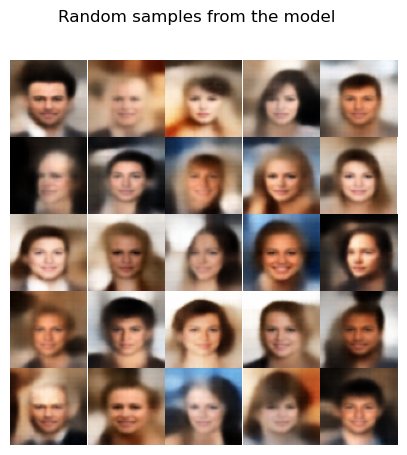

In [58]:
test_with_random_samples(model, device, 5, 5)

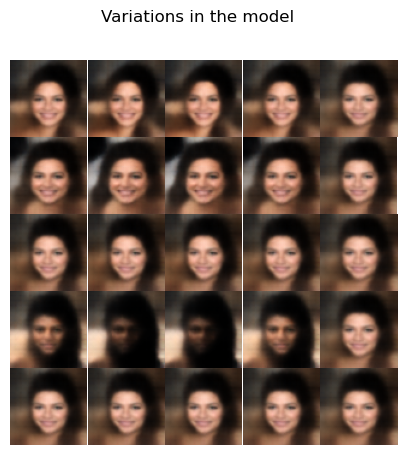

In [55]:
test_with_variations(model, device, 5, 5, 2)

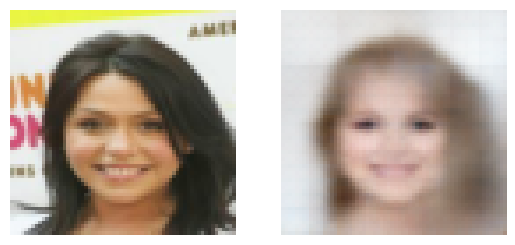

In [21]:
test_with_dataset(model, device, test_loader)

In [11]:
test(model, device, test_loader)

====> Test set loss: 0.4268
